In [1]:
import csv
import numpy as np
from collections import defaultdict
from matplotlib import pyplot
import pandas

In [2]:
BLANKS=["","RBNF1", "RBNF2", "RBNF", "0", "RBNF 1", "RBNF 2"]
#TOTAL= 5048
TOTAL=2734
#TOTAL=1351
#TOTAL=1201
#TOTAL=1168


In [3]:
def loadCsvData(fileName):
	matrix = []
	# open a file
	with open(fileName) as f:
		reader = csv.reader(f)

		# loop over each row in the file
		for row in reader:

			# cast each value to a float
			doubleRow = []
			for value in row:
				doubleRow.append(value.strip())

			# store the row into our matrix
			matrix.append(doubleRow)
	return matrix

In [4]:
def printData(matrix):
	for row in matrix:
		print (row)

In [5]:
data= loadCsvData("data/metadata.csv")

In [6]:
data=pandas.DataFrame(data[1:], columns=data[0])

In [7]:
database=defaultdict(lambda: defaultdict(lambda:0))
for i in range(len(data)):
    for atr in data.columns:
        if atr== "researcher_assumed_birth_decade":
            continue
        if atr== "researcher_assumed_race":
            continue
        value= data[atr][i]
        if value in BLANKS and atr=="\ufeffbirth_decade":
            value= data.loc[i, "researcher_assumed_birth_decade"]
        if value in BLANKS and atr=="identified_race":
            value= data.loc[i, "researcher_assumed_race"]
        database[data.loc[i, "interviewee_id"]][atr]=value

In [8]:
interviewtxt =loadCsvData("data/interview text fille to ids.csv")

In [9]:
interviewtxt=pandas.DataFrame(interviewtxt[1:], columns=interviewtxt[0])


In [10]:
text_to_ids={}
for i in range(len(interviewtxt)):
    name=interviewtxt.at[i, interviewtxt.columns[0]]
    name=name[:name.rfind('.')]
    name=name.replace('\'','_')
    text_to_ids[name]=interviewtxt["interviewee_ids"][i].split(';')

In [11]:
ids_to_years=defaultdict(lambda: "0")
for i in range(len(interviewtxt)):
    date=interviewtxt["date_of_first_interview"][i]
    year=date[date.rfind('/')+1:]
    ids=interviewtxt["interviewee_ids"][i].split(';')
    for num in ids:
        ids_to_years[num]= str(year)

In [12]:
database=defaultdict(lambda: defaultdict(lambda:0))
for i in range(len(data)):
    for atr in data.columns:
        if atr== "researcher_assumed_birth_decade":
            continue
        if atr== "researcher_assumed_race":
            continue
        value= data[atr][i]
        if value in BLANKS and atr=="\ufeffbirth_decade":
            value= data.loc[i, "researcher_assumed_birth_decade"]
        if value in BLANKS and atr=="identified_race":
            value= data.loc[i, "researcher_assumed_race"]
        database[data.loc[i, "interviewee_id"]][atr]=value
    database[data.loc[i, "interviewee_id"]]["interview_year"]=ids_to_years[data.loc[i, "interviewee_id"]]

In [13]:
dataformatted=defaultdict(lambda: defaultdict(lambda:0))
k=0
for i in database : 
    if database[i]["sex"]=="Male":
        continue
    for atr in database[i]:
        value= database[i][atr]
        if value not in BLANKS:
            dataformatted[atr][value]+=1
print(dataformatted["interview_year"])
for cat in dataformatted:
    total=0
    for x in dataformatted[cat]:
        total+= dataformatted[cat][x]
    dataformatted[cat]["No Info"]= TOTAL-total
        
print(k)
    
        

defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fedc9b31e18>, {'1977': 32, '1976': 20, '1979': 10, '1985': 11, '1978': 22, '1980': 4, '1974': 19, '1987': 12, '1982': 20, '1988': 49, '2013': 175, '1986': 14, '1972': 4, '2015': 121, '1996': 7, '1981': 3, '1990': 5, '1983': 1, '1995': 3, '2017': 57, '2006': 113, '2018': 9, '1992': 4, '1989': 4, '2005': 132, '1994': 4, '2014': 168, '2016': 130, '1993': 3, '2012': 184, '1998': 7, '1997': 9, '1999': 8, '2007': 218, '2009': 68, '2008': 128, '2003': 119, '2010': 173, '2000': 24, '2001': 60, '2011': 168, 'July, 1977': 1, '2002': 93, '2004': 114, '1973': 5, '1975': 9, '1976-04': 1, '1991': 1})
0


In [14]:
unknown=[]
for x in database:
    if database[x]['current_or_most_recent_occupation'] in BLANKS and database[x]["sex"]!="Male":
        unknown.append(database[x]["interviewee_name"])


In [15]:
for table in dataformatted:
    for x,y in dataformatted[table].items():
        print("{}: {}".format(x,y))
        #print(x)
        #print(y)

1890: 64
1900: 109
1910: 288
1880: 13
1930: 466
1870: 2
1940: 608
1920: 455
1950: 396
1980: 41
1960: 184
1970: 67
1990: 8
1970-1980: 1
1950s: 1
1940s: 1
No Info: 30
Black or African American: 1201
White: 1351
Asian: 42
Hispanic/Latinx: 29
Other Race: 5
Two or More Races: 27
Indigenous American or Alaska Native: 67
No Info: 12
Married (except if separated): 970
Widowed: 247
Divorced: 154
Never married: 72
Separated: 3
Single: 52
Domestic Partner: 1
Common Law: 1
No Info: 1234
High school graduate: 205
Bachelor's degree: 638
Graduate or professional degree: 1168
Associate's degree: 36
Some college: 412
9th to 12th grade but no diploma: 114
Less than 9th grade: 41
No Info: 120
Female: 2734
No Info: 0
Abbott, Jessie: 1
Adair, Christia: 1
Adams, Frankie V.: 1
Adams, Kathleen Redding: 1
Albrier, Frances Mary: 1
Alexander, Margaret Walker: 1
Alexander, Sadie: 1
Barker, Elizabeth Cordozo: 1
Barnett, Etta Moten: 1
Boyd, Norma: 1
Cass, Melnea: 1
Chinn, May Edward: 1
Craft, Juanita Jewel: 1
Dicks

McCullough, Geraldine: 1
Manning, Blanche: 1
Love, Rebecca: 1
Rankin, Marlene: 1
Leavell, Dorothy: 1
Middlebrooks - Hill, Felicia: 1
Adams, Carol: 1
Sizemore, Barbara: 1
Lewis, Elma: 1
Campbell, Zerrie: 1
Ladd, Florence: 1
Sanchez, Sonia: 1
Lambert, Jerline: 1
Herman, Alexis: 1
Billingsley, Amy: 1
Hemphill, Gloria: 1
Carne, Jean: 1
Woodson, Susan: 1
Hall, Sophia: 1
Daniel, Elnora: 1
Williams, E.: 1
Murphy, Constance: 1
Murphy, Frances: 1
Dawson, Lula: 1
Davis, Angela: 1
Ladner, Joyce: 1
Ray, Adine: 1
Dellums, Leola "Roscoe": 1
Jarvis, Charlene: 1
Bundles, A'Lelia: 1
Pierre, Zina: 1
Hewitt, Vivian: 1
Nelson West, Bennetta: 1
Clanton, Erma: 1
Edelin, Ramona: 1
Seon, Yvonne: 1
Jackson, Alexine: 1
Groomes, Thelma: 1
Daley, Thelma: 1
Aiyetoro, Adjoa: 1
Jones, Doris: 1
DeCosta-Willis, Miriam: 1
Scruggs-Leftwich, Yvonne: 1
Ashmore-Hudson, Anne: 1
Hobson, Mellody: 1
McDowell, Helen: 1
Grant, Jacquelyn: 1
Williams, Jamye: 1
Malveaux, Antoinette: 1
Gray, Joan: 1
Hassan-Fletcher, Bernyce: 1
Lewis

VEE526: 1
VEE527: 1
VEE528: 1
VEE529: 1
VEE530: 1
VEE531: 1
VEE532: 1
VEE533: 1
VEE534: 1
VEE535: 1
VEE536: 1
VEE537: 1
VEE538: 1
VEE539: 1
VEE540: 1
VEE541: 1
VEE542: 1
VEE543: 1
VEE544: 1
VEE545: 1
VEE546: 1
VEE547: 1
VEE548: 1
VEE549: 1
VEE550: 1
VEE551: 1
VEE552: 1
VEE553: 1
VEE554: 1
VEE555: 1
VEE556: 1
VEE557: 1
VEE558: 1
VEE559: 1
VEE560: 1
VEE561: 1
VEE562: 1
VEE563: 1
VEE564: 1
VEE565: 1
VEE566: 1
VEE567: 1
VEE568: 1
VEE569: 1
VEE570: 1
VEE571: 1
VEE572: 1
VEE573: 1
VEE574: 1
VEE575: 1
VEE576: 1
VEE577: 1
VEE578: 1
VEE579: 1
VEE580: 1
VEE581: 1
VEE582: 1
VEE583: 1
VEE584: 1
VEE585: 1
VEE586: 1
VEE587: 1
VEE588: 1
VEE589: 1
VEE590: 1
VEE591: 1
VEE592: 1
VEE593: 1
VEE594: 1
VEE595: 1
VEE596: 1
VEE597: 1
VEE598: 1
VEE599: 1
VEE600: 1
VEE601: 1
VEE602: 1
VEE603: 1
VEE604: 1
VEE605: 1
VEE606: 1
VEE607: 1
VEE608: 1
VEE609: 1
VEE610: 1
VEE611: 1
VEE612: 1
VEE613: 1
VEE614: 1
VEE615: 1
VEE616: 1
VEE617: 1
VEE618: 1
VEE619: 1
VEE620: 1
VEE621: 1
VEE622: 1
VEE623: 1
VEE624: 1
VEE625: 1


VEE3217: 1
VEE3220: 1
VEE3222: 1
VEE3223: 1
VEE3224: 1
VEE3225: 1
VEE3226: 1
VEE3227: 1
VEE3229: 1
VEE3235: 1
VEE3239: 1
VEE3241: 1
VEE3243: 1
VEE3244: 1
VEE3246: 1
VEE3247: 1
VEE3248: 1
VEE3252: 1
VEE3256: 1
VEE3257: 1
VEE3262: 1
VEE3266: 1
VEE3283: 1
VEE3285: 1
VEE3286: 1
VEE3294: 1
VEE3296: 1
VEE3298: 1
VEE3299: 1
VEE3303: 1
VEE3309: 1
VEE3312: 1
VEE3313: 1
VEE3315: 1
VEE3319: 1
VEE3320: 1
VEE3331: 1
VEE3332: 1
VEE3333: 1
VEE3341: 1
VEE3342: 1
VEE3343: 1
VEE3344: 1
VEE3345: 1
VEE3346: 1
VEE3350: 1
VEE3352: 1
VEE3354: 1
VEE3357: 1
VEE3358: 1
VEE3359: 1
VEE3360: 1
VEE3367: 1
VEE3371: 1
VEE3372: 1
VEE3373: 1
VEE3374: 1
VEE3375: 1
VEE3377: 1
VEE3380: 1
VEE3381: 1
VEE3382: 1
VEE3384: 1
VEE3394: 1
VEE3398: 1
VEE3400: 1
VEE3402: 1
VEE3404: 1
VEE3405: 1
VEE3406: 1
VEE3408: 1
VEE3409: 1
VEE3411: 1
VEE3414: 1
VEE3417: 1
VEE3424: 1
VEE3427: 1
VEE3429: 1
VEE3435: 1
VEE3437: 1
VEE3440: 1
VEE3442: 1
VEE3444: 1
VEE3446: 1
VEE3453: 1
VEE3455: 1
VEE3457: 1
VEE3458: 1
VEE3459: 1
VEE3460: 1
VEE3462: 1

Professor; Child Development Researcher; College Department Head: 1
Golf coach: 1
Medical Technologist: 2
Cattle Rancher: 2
Bank Teller: 1
Professional Quilter: 1
Pianist: 1
Administrative Worker: 1
Professor of Home Economics: 1
Newspaper Proofreader: 2
help in family business: 1
Real Estate Broker: 3
secretary: 1
business manager for university: 1
county demonstration agent: 1
Nursing Home Administrator: 1
County Board Member: 1
Post Office Worker: 1
Home Health Department Assistant: 1
Baliff: 1
Director of Nursing Program: 1
Curator: 3
Grocery Store Employee: 1
RNF1: 1
Treasurer: 1
Bank Assistant: 1
Arts adiministrator, education administrator: 1
CEO of tech company: 1
University professor, university administrator: 3
Nonprofit director, entrepreneur: 1
Women's basketball coach: 1
State senator: 1
County comissioner: 1
State legislature representative: 1
Counseling psychologist, university professor: 1
Nonprofit director, university professor: 1
Nonprofit director, disability rights

In [16]:
#def checkAProfile(data, race, sex, education, birthdecade, exact):
#    total=0
#    attr=[("identified_race", race), ("sex", sex), ("education", education), ("\ufeffbirth_decade", birthdecade)]
#    for i in data: 
#        if exact:
#            skip=False
#            for a in attr:
#                if data[i][a[0]] in BLANKS and a[1] != "":
#                    skip=True
#           if skip:
#                continue
#        skip=False   
#        for a in attr:
#            cat= data[i][a[0]]
#            if a[1] != "" and cat not in BLANKS and cat != a[1]:
#                skip=True
#        if skip:
#            continue
#        total+=1
#    return total
    
    

In [17]:
ids_to_info=defaultdict(lambda: defaultdict(lambda:0))
for ids in database:
    ids_to_info[ids]["birth_decade"]=database[ids]["\ufeffbirth_decade"]
    ids_to_info[ids]["education"]=database[ids]["education"]
    ids_to_info[ids]["collection"]=database[ids]["collection_id"]
    ids_to_info[ids]["sex"]=database[ids]["sex"]
    ids_to_info[ids]["race"]=database[ids]["identified_race"]
    ids_to_info[ids]["interview_year"]=database[ids]["interview_year"]
print(ids_to_info)

defaultdict(<function <lambda> at 0x7fedc9b83378>, {'VEE0': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fedc9b83950>, {'birth_decade': '1890', 'education': 'High school graduate', 'collection': 'BWOH', 'sex': 'Female', 'race': 'Black or African American', 'interview_year': '1977'}), 'VEE1': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fedc9b836a8>, {'birth_decade': '1890', 'education': "Bachelor's degree", 'collection': 'BWOH', 'sex': 'Female', 'race': 'Black or African American', 'interview_year': '1977'}), 'VEE2': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fedc9b318c8>, {'birth_decade': '1900', 'education': 'Graduate or professional degree', 'collection': 'BWOH', 'sex': 'Female', 'race': 'Black or African American', 'interview_year': '1977'}), 'VEE3': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fedc9b31f28>, {'birth_decade': '1890', 'education': "Associate's degree", 'collection': 'BWOH', 'sex': 'Female', 'race': 'Black or African American'

In [18]:
myfile = open("data/everything_but_falsehits_and_needsreview.txt")
txt = myfile.read()
myfile.close()

files=[]
tokens=txt.split()
for i in tokens:
    num= i.find("Files\\\\")
    if not num==-1:
        if not i.find("_")==-1:
            files.append(i.strip())
names=set()
for i in files:
    i=i[i.find("\\\\",8)+2:-1]
    names.add(i.strip())


In [46]:
decades=[]
for i in range(1870, 2000, 10):
    decades.append(str(i))
decades.append("No Info")
total=[]
for i in decades:
    total.append(dataformatted["\ufeffbirth_decade"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["birth_decade"]]+=1
hits_formatted=[]
for i in decades:
    hits_formatted.append(hits[i])
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
print(totalnum)
for i in range(len(decades)):
    percentage_withNI.append(int(hits_formatted[i]/total[i]*100))
    #if not i==len(decades)-1:
    #    percentage_noNI.append(int(hits_formatted[i]/(total[i])*100))
#percentage_noNI.append(None)


2731


In [47]:
df_decades = pandas.DataFrame([total, hits_formatted, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage of total"],columns=decades)

In [48]:
display(df_decades)

,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,No Info
total corpus,2,13,64,109,288,455,466,608,396,184,67,41,8,30
in rape cluster,0,2,14,18,24,56,65,151,90,38,13,7,0,0
Percentage of total,0,15,21,16,8,12,13,24,22,20,19,17,0,0


In [50]:
race=[]
for i in dataformatted["identified_race"]:
    race.append(i)
race.remove("No Info")
race.sort()
race.append("No Info")
total=[]
for i in race:
    total.append(dataformatted["identified_race"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["race"]]+=1
hits_formatted=[]
for i in race:
    hits_formatted.append(hits[i])
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
for i in range(len(race)):
    percentage_withNI.append(int(hits_formatted[i]/total[i]*100))
    #if not i==len(race)-1:
    #    percentage_noNI.append(int(hits_formatted[i]/(totalnum-total[-1])*100))
#percentage_noNI.append(None)

In [51]:
df_race = pandas.DataFrame([total, hits_formatted, percentage_withNI],index=["total corpus", "in rape cluster", "Percentage of total"], columns=race)

In [52]:
display(df_race)

,Asian,Black or African American,Hispanic/Latinx,Indigenous American or Alaska Native,Other Race,Two or More Races,White,No Info
total corpus,42,1201,29,67,5,27,1351,12
in rape cluster,14,270,6,5,1,6,177,0
Percentage of total,33,22,20,7,20,22,13,0


In [60]:
education=["Less than 9th grade", "9th to 12th grade but no diploma", "High school graduate", "Some college", "Associate's degree", "Bachelor's degree", "Graduate or professional degree", "No Info"]
total=[]
for i in education:
    total.append(dataformatted["education"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["education"]]+=1
hits_formatted=[]
for i in education:
    hits_formatted.append(hits[i])
total_correct=[sum(total[0:3]), sum(total[3:6]), total[-2], total[-1]]
hits_formatted_correct=[sum(hits_formatted[0:3]), sum(hits_formatted[3:6]), hits_formatted[-2], hits_formatted[-1]]
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
for i in range(4):
    percentage_withNI.append(int(hits_formatted_correct[i]/total_correct[i]*100))
    #if not i==3:
    #    percentage_noNI.append((hits_formatted_correct[i]/(totalnum-total[-1])*100))
#percentage_noNI.append(None)

In [61]:
df_education = pandas.DataFrame([total_correct, hits_formatted_correct, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage of total"], columns=["up to 12th grade", "up to college degree", "graduate or professional degree", "no info"])

In [62]:
display(df_education)

,up to 12th grade,up to college degree,graduate or professional degree,no info
total corpus,360,1086,1168,120
in rape cluster,41,185,241,0
Percentage of total,11,17,20,0


In [76]:
years=[]
for i in range(1972, 2019, 1):
    years.append(str(i))
years.append("No Info")
total=[]
for i in years:
    total.append(dataformatted["interview_year"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]
    for num in id_nums:
        hits[ids_to_info[num]["interview_year"]]+=1
hits_formatted=[]
for i in years:
    hits_formatted.append(hits[i])
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
print(totalnum)
for i in range(len(years)):
    if total[i]==0:
        percentage_withNI.append(0)
    else:    
        percentage_withNI.append(int(hits_formatted[i]/total[i]*100))
    #if not i==len(years)-1:
    #    percentage_noNI.append((hits_formatted[i]/(totalnum-total[-1])*100))
#percentage_noNI.append(None)

2732


In [77]:
df_interview_year = pandas.DataFrame([total, hits_formatted, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage of total"], columns=years)

In [78]:
pandas.options.display.max_columns = None

In [80]:
display(df_interview_year)

,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,No Info
total corpus,4,5,19,9,20,32,22,10,4,3,20,1,0,11,14,12,49,4,5,1,4,3,4,3,7,9,7,8,24,60,93,119,114,132,113,218,128,68,173,168,184,175,168,121,130,57,9,188
in rape cluster,1,0,4,2,9,9,9,2,0,0,1,0,0,2,1,3,6,0,1,0,1,0,0,1,0,2,1,1,2,7,24,33,20,33,27,41,19,7,28,39,30,36,38,10,13,12,5,0
Percentage of total,25,0,21,22,45,28,40,20,0,0,5,0,0,18,7,25,12,0,20,0,25,0,0,33,0,22,14,12,8,11,25,27,17,25,23,18,14,10,16,23,16,20,22,8,10,21,55,0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

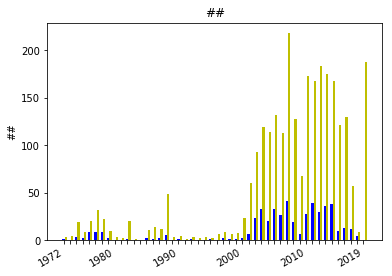

In [31]:
N = 48

ind = np.arange(N) 
values=[]
totals=[]

# some example data

values=hits_formatted
    
    
values = np.array(values)
total=np.array(total)


x = range(len(values))


# and plot it
fig, ax = pyplot.subplots()
hm=ax.bar(ind, values, 0.35, color="b")
total=ax.bar(ind+.35, total, .35, color="y")
ax.set_xticks(ind)
ax.set_xticklabels((1972,"","","","","","","",1980,"","","","","","","","","",1990,"","","","","","","","","",2000,"","","","","","","","","",2010,"","","","","","","","",2019))
ax.set_title('##')
ax.set_ylabel('##')
pyplot.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

